Unsupervised ML approaches to explore human melanoma gene expression datasets - code adapted from the Fred Hutch PanCancer bootcamp (https://github.com/fredhutchio/practice-machine-learning)

Using bulk transcriptomics data to predict whether or not samples are derived from primary tumors or metastases. 

Datasets were downloaded and pre-processed using TCGAbiolinks package in R.  

In [11]:
# Data Manipulation
import pandas as pd
import numpy as np

# Statistics
from scipy import stats
import statsmodels.api as sm

# Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# visualization
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

# setting up the plot style
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def create_genes_subset(split_size=.2):
    """
        Creates a smaller dataframe from the large 'genes.csv' file based on a split from the metadata file.
        Returns a dataframe that has been transformed by log2 and the index needed for the remaining samples
        from the genes.csv file to remain independent.
    
    """
    
    metadata = pd.read_csv('metadata.csv')
    
    big_split, small_split = train_test_split(metadata, test_size=split_size, random_state=4)
    
    skiplines_small = np.sort(big_split.index) + 1 
    skiplines_big = np.sort(small_split.index) + 1
    
    genes_small = pd.read_csv('genes.csv', skiprows=skiplines_small)
    
    genes_nonAllZero = genes_small.loc[:,~genes_small.isin([0]).all(axis=0)]
    
    genes_log2_trans = np.log2(genes_nonAllZero.iloc[:,1:] + 1)
    genes_log2_trans['barcode'] = genes_small['barcode']
    
    genes_merged = pd.merge(left=small_split, right=genes_log2_trans, how='left', left_on='barcode', right_on='barcode')
    
    # Releasing memory by deleting dataframes
    del genes_small, genes_nonAllZero, genes_log2_trans, skiplines_small, skiplines_big
    
    return genes_merged, big_split, small_split


In [3]:
genes_merged, big_split, small_split = create_genes_subset(split_size=.95)

In [4]:
genes_merged = genes_merged[genes_merged.ajcc_pathologic_stage != 'Not Reported']

genes_merged['ajcc_pathologic_stage'] = genes_merged['ajcc_pathologic_stage'].replace(['Stage IA','Stage IB'],'Stage I')
genes_merged['ajcc_pathologic_stage'] = genes_merged['ajcc_pathologic_stage'].replace(['Stage IIA','Stage IIB', 'Stage IIC'],'Stage II')
genes_merged['ajcc_pathologic_stage'] = genes_merged['ajcc_pathologic_stage'].replace(['Stage IIIA','Stage IIIB', 'Stage IIIC'],'Stage III')



In [26]:
data = genes_merged.drop(columns=['barcode', 'shortLetterCode', 'ajcc_pathologic_stage', 
           'patient', 'sample_type', 'days_to_collection', 'tissue_or_organ_of_origin', 
           'primary_diagnosis', 'age_at_index', 'year_of_diagnosis', 'gender', 
           'race', 'ethnicity', 'vital_status', 'days_to_death'])
data = data.dropna()

In [27]:
X = data.drop(columns='definition') # getting only the gene count as features
X = MinMaxScaler().fit_transform(X) # Normalizing the features

In [28]:
#make the labels into factors 
Y = pd.factorize(data['definition'])[0]

In [34]:
data

,definition,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,...,ENSG00000288658.1,ENSG00000288659.1,ENSG00000288660.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288674.1,ENSG00000288675.1
0,Primary solid Tumor,9.548822,0.000000,9.726218,8.876517,7.761551,5.781360,7.693487,10.393390,10.149747,...,6.714246,0.0,0.0,0.0,4.857981,0.0,0.000000,8.092757,4.000000,4.807355
1,Metastatic,12.909143,0.000000,10.804938,9.592457,8.810572,10.215533,13.563673,11.597587,10.653741,...,5.392317,0.0,0.0,0.0,3.807355,0.0,0.000000,8.523562,1.584963,5.209453
2,Metastatic,10.520619,1.000000,10.264443,8.823367,8.581201,8.330917,10.969387,11.061371,9.949827,...,1.584963,0.0,0.0,0.0,4.459432,0.0,0.000000,6.491853,3.000000,4.700440
3,Metastatic,10.368506,2.321928,9.560333,8.607330,6.882643,3.584963,8.618386,10.278449,9.131857,...,3.169925,0.0,0.0,0.0,4.392317,0.0,0.000000,8.366322,2.000000,3.700440
4,Metastatic,11.569856,0.000000,11.153552,9.661778,9.461479,7.434628,8.832890,10.881879,9.799282,...,3.584963,0.0,1.0,0.0,4.754888,0.0,1.000000,8.651052,0.000000,4.459432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,Metastatic,11.669771,1.584963,11.180531,9.682995,9.873444,7.330917,9.197217,11.828533,11.268542,...,6.321928,1.0,0.0,0.0,2.321928,0.0,0.000000,8.994353,2.584963,3.906891
446,Metastatic,8.661778,4.321928,10.459432,9.499846,7.507795,11.384784,11.453271,9.623881,10.427313,...,1.584963,0.0,0.0,0.0,5.754888,0.0,3.321928,7.643856,2.807355,3.807355
447,Metastatic,11.736825,0.000000,9.867279,10.145932,9.903882,8.361944,11.909143,10.859535,11.178042,...,8.044394,0.0,1.0,0.0,4.643856,0.0,0.000000,9.236014,2.807355,4.523562
448,Metastatic,10.642052,3.000000,11.286558,9.543032,9.961450,12.033767,11.455841,10.964341,10.980854,...,5.169925,1.0,0.0,0.0,4.700440,0.0,0.000000,6.857981,3.169925,4.000000


In [40]:
# importing desired model
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Call sklearn k-means clustering for 5 clusters
kmeans = KMeans(n_clusters=2).fit(X)

# Use PCA to reduce features for visualization
pca_genes = PCA(n_components=3).fit_transform(X)

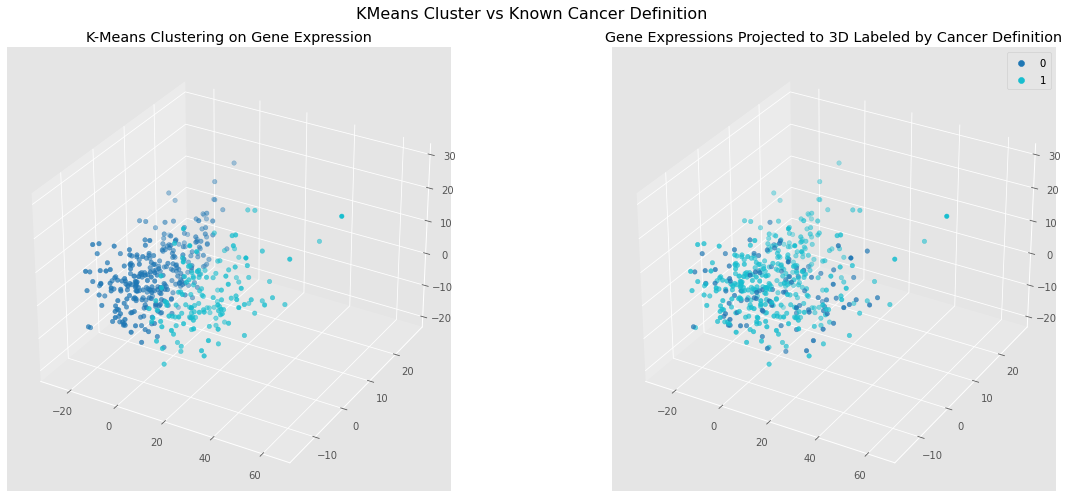

In [41]:
# Use Matplotlib to visualize in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(18)

# Kmeans clusters by using kmeans.labels as color
ax = fig.add_subplot(1,2,1, projection='3d')
ax.set_title("K-Means Clustering on Gene Expression")
ax.scatter(pca_genes[:,0], pca_genes[:,1], pca_genes[:,2], c=kmeans.labels_, cmap='tab10')

# Do the same but color by cancer type
ax = fig.add_subplot(1,2,2, projection='3d')
labels = {"Primary solid Tumor": 0, "Metastatic": 1 }
ax.set_title("Gene Expressions Projected to 3D Labeled by Cancer Definition")
ct_scatter = ax.scatter(pca_genes[:,0], pca_genes[:,1], pca_genes[:,2], 
                        c=data['definition'].map(labels), cmap='tab10')

# produce a legend with the unique colors from the scatter
ax.add_artist(ax.legend(*ct_scatter.legend_elements()))

plt.tight_layout(pad=1)
plt.subplots_adjust(top=0.9)

fig.suptitle('KMeans Cluster vs Known Cancer Definition', fontsize=16)
plt.savefig('Kmeans_Cluster.png')
plt.show()

Gaussian Mixture Model 

In [38]:
# import GMM 
from sklearn.mixture import GaussianMixture
# Set up the GMM using scikitlearn
gmm = GaussianMixture(n_components=2)
# fit
gmm.fit(pca_genes)

GaussianMixture(n_components=2)

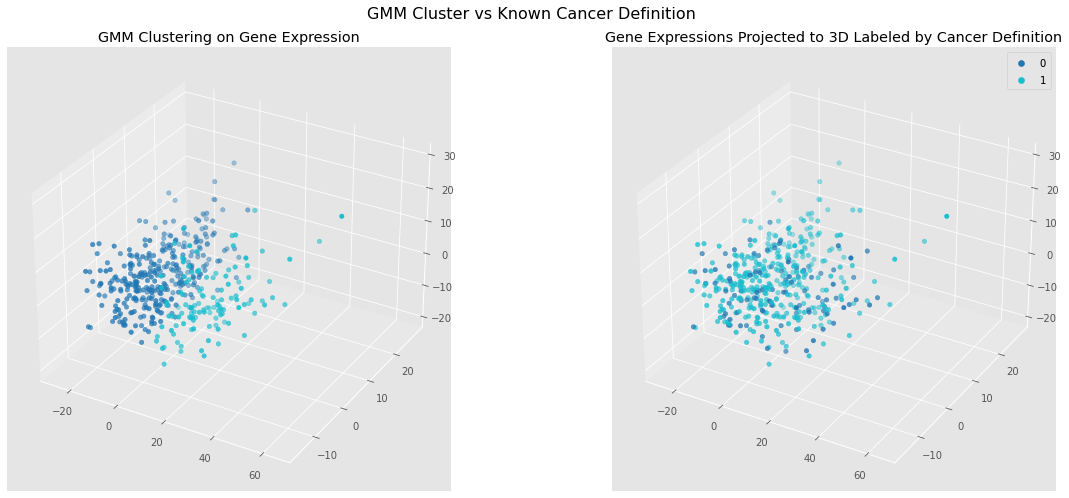

In [39]:
# Use the GMM to assign a label to each point
labels = gmm.predict(pca_genes)

# Visualize the results
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(18)

ax = fig.add_subplot(121, projection='3d')
ax.set_title("GMM Clustering on Gene Expression")
ax.scatter(pca_genes[:,0], pca_genes[:,1], pca_genes[:,2], c=labels, cmap='tab10')

# Do the same but color by cancer type
ax = fig.add_subplot(1,2,2, projection='3d')
labels = {"Primary solid Tumor": 0, "Metastatic": 1 }
ax.set_title("Gene Expressions Projected to 3D Labeled by Cancer Definition")
ct_scatter = ax.scatter(pca_genes[:,0], pca_genes[:,1], pca_genes[:,2], 
                        c=data['definition'].map(labels), cmap='tab10')

# produce a legend with the unique colors from the scatter
ax.add_artist(ax.legend(*ct_scatter.legend_elements()))

plt.tight_layout(pad=1)
plt.subplots_adjust(top=0.9)

fig.suptitle('GMM Cluster vs Known Cancer Definition', fontsize=16)
plt.savefig('GMM_Cluster.png')
plt.show()